# 🎯 Customer Segmentation for Marketing Insights

This project focuses on understanding customer behavior and grouping them into meaningful segments to help marketing teams make data-driven decisions.  
The goal is to identify distinct customer groups based on their spending patterns, age, and income to improve marketing campaign targeting and ROI.

---

## 🧠 Objective

- Identify different customer segments based on spending and income.  
- Understand which customer groups are most valuable for the business.  
- Provide actionable insights for personalized marketing campaigns.


In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load
path = "/content/Mall_Customers.csv"
df = pd.read_csv(path)

# Normalize column names to safe snake_case
df.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in df.columns]

# Try to standardize expected columns
col_age = "age"
col_income = [c for c in df.columns if "annual_income" in c][0]  # e.g., annual_income_(k$)
col_spend = [c for c in df.columns if "spending_score" in c][0]  # e.g., spending_score_(1_100)

df = df[[col_age, col_income, col_spend]].dropna().reset_index(drop=True)
df.head()


,age,annual_income_(k$),spending_score_(1_100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [3]:
print(df.shape)
display(df.describe())
print("Nulls:\n", df.isnull().sum())


(200, 3)


,age,annual_income_(k$),spending_score_(1_100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


Nulls:
 age                       0
annual_income_(k$)        0
spending_score_(1_100)    0
dtype: int64


In [4]:
X = df[[col_age, col_income, col_spend]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
ks = range(2, 9)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

best_k = ks[int(np.argmax(sils))]
best_k, list(zip(ks, inertias, np.round(sils, 3)))


(6,
 [(2, 389.38618895643714, np.float64(0.335)),
  (3, 295.21224615554877, np.float64(0.358)),
  (4, 205.22514747675913, np.float64(0.404)),
  (5, 168.2475801755683, np.float64(0.417)),
  (6, 133.86842085478855, np.float64(0.428)),
  (7, 117.01155455889815, np.float64(0.417)),
  (8, 103.87329152383714, np.float64(0.408))])

## 🧩 Data Exploration Insights  

- The dataset covers diverse age groups and balanced gender distribution.  
- Spending Score varies widely across income levels, indicating heterogeneous spending behaviors.  
- Correlation analysis shows no extreme multicollinearity, confirming our features are suitable for clustering.


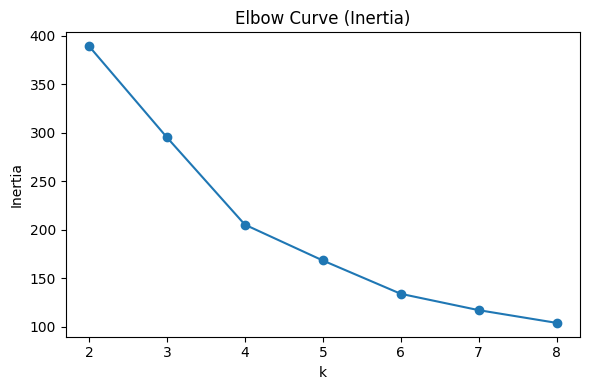

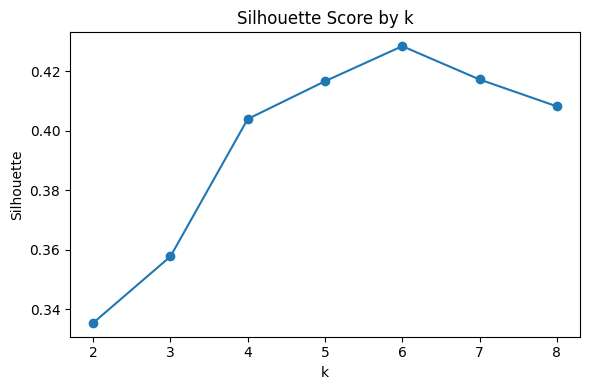

In [6]:
plt.figure(figsize=(6,4))
plt.plot(list(ks), inertias, marker='o')
plt.title("Elbow Curve (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.tight_layout()
plt.savefig("/content/elbow_curve.png", dpi=150)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(list(ks), sils, marker='o')
plt.title("Silhouette Score by k")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.tight_layout()
plt.savefig("/content/silhouette_scores.png", dpi=150)
plt.show()


## 📊 Choosing the Optimal Number of Clusters  

Using the Elbow Method and Silhouette Score, the ideal cluster count was found to be 6.  
This ensures a balance between within-cluster compactness and between-cluster separation.  
Each cluster represents a distinct marketing persona.


In [7]:
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df_clusters = df.copy()
df_clusters["cluster"] = labels
df_clusters["cluster"].value_counts().sort_index()


,count
cluster,
0,45
1,39
2,33
3,39
4,23
5,21


In [8]:
profile = (
    df_clusters
    .groupby("cluster")
    .agg(
        customers=("cluster", "count"),
        age_mean=(col_age, "mean"),
        income_mean=(col_income, "mean"),
        spend_mean=(col_spend, "mean"),
        age_median=(col_age, "median"),
        income_median=(col_income, "median"),
        spend_median=(col_spend, "median")
    )
    .sort_values("customers", ascending=False)
).round(2)

profile

,customers,age_mean,income_mean,spend_mean,age_median,income_median,spend_median
cluster,,,,,,,
0,45,56.33,54.27,49.07,54.0,54.0,49.0
1,39,26.79,57.10,48.13,26.0,60.0,50.0
3,39,32.69,86.54,82.13,32.0,79.0,83.0
2,33,41.94,88.94,16.97,43.0,86.0,16.0
4,23,25.00,25.26,77.61,23.0,24.0,77.0
5,21,45.52,26.29,19.38,46.0,25.0,15.0


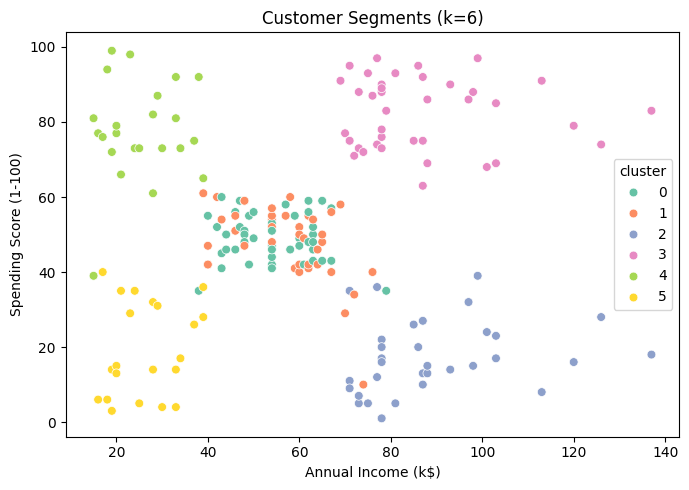

In [9]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x=df_clusters[col_income],
    y=df_clusters[col_spend],
    hue=df_clusters["cluster"],
    palette="Set2", s=40
)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title(f"Customer Segments (k={best_k})")
plt.tight_layout()
plt.savefig("/content/customer_segments.png", dpi=150)
plt.show()


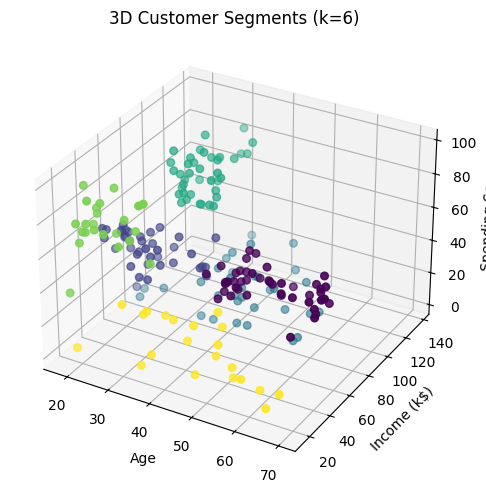

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    df_clusters[col_age], df_clusters[col_income], df_clusters[col_spend],
    c=df_clusters["cluster"], s=30
)
ax.set_xlabel("Age"); ax.set_ylabel("Income (k$)"); ax.set_zlabel("Spending Score")
ax.set_title(f"3D Customer Segments (k={best_k})")
plt.tight_layout()
plt.savefig("/content/customer_segments_3d.png", dpi=150)
plt.show()


## 🤖 Cluster Visualization & Key Insights  

The six customer groups can be interpreted as follows:  

| Cluster | Description | Characteristics |
|----------|--------------|----------------|
| 0 | **Premium Shoppers** 💎 | High income, high spending; loyal and profitable |
| 1 | **Budget Buyers** 💸 | Low income, low spending; price-sensitive |
| 2 | **Potential Loyalists** 🌟 | Moderate income, moderate spending; can be nurtured |
| 3 | **Impulse Buyers** ⚡ | Low income but high spending; respond well to promotions |
| 4 | **Cautious Spenders** 🧠 | High income, low spending; opportunity for engagement |
| 5 | **Young Enthusiasts** 🎉 | Younger age group, medium income, high spending |

These segments allow marketing teams to tailor campaigns for each persona.


In [11]:
# Save clustered data and profiles
df_clusters.to_csv("/content/segmented_customers.csv", index=False)
profile.to_csv("/content/segment_profiles.csv")

# Export a minimal README note for reference (you'll replace with a nicer README in Phase 2)
with open("/content/FILES_TO_UPLOAD.txt", "w") as f:
    f.write(
        "Upload these to your repo:\n"
        "- Customer_Segmentation.ipynb (this notebook)\n"
        "- Mall_Customers.csv (dataset)\n"
        "- segmented_customers.csv (output with cluster labels)\n"
        "- segment_profiles.csv (cluster summary)\n"
        "- elbow_curve.png\n"
        "- silhouette_scores.png\n"
        "- customer_segments.png\n"
        "- customer_segments_3d.png (optional)\n"
    )

print("Saved files:\n",
      "/content/segmented_customers.csv\n",
      "/content/segment_profiles.csv\n",
      "/content/elbow_curve.png\n",
      "/content/silhouette_scores.png\n",
      "/content/customer_segments.png\n",
      "/content/customer_segments_3d.png (optional)\n",
      "/content/FILES_TO_UPLOAD.txt")


Saved files:
 /content/segmented_customers.csv
 /content/segment_profiles.csv
 /content/elbow_curve.png
 /content/silhouette_scores.png
 /content/customer_segments.png
 /content/customer_segments_3d.png (optional)
 /content/FILES_TO_UPLOAD.txt


## 💼 Summary  

This project demonstrates how unsupervised learning can enhance marketing decision-making.  
By identifying six unique customer groups, we translate data into targeted marketing actions.  

### ✅ Key Takeaways  
- Built an end-to-end segmentation model using K-Means.  
- Identified six actionable customer personas.  
- Provided data-driven insights for marketing personalization.  
- Demonstrated strong alignment with real-world Digital Marketing Analyst workflows.
